# ASTR 8060 Homework 5
## Hannah Dattilo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import astropy.io.fits as fits
import ccdproc as ccd
from astropy.nddata import CCDData
from astropy.modeling import models, fitting
from astropy.stats import mad_std
from astropy.stats import sigma_clip
import sys 
sys.path.insert(0,'./ccd-reduction-and-photometry-guide/notebooks/')
from convenience_functions import show_image

## 1: Examine your individual flats for the V filter. Are there significant artifacts? How might we combine the frames into a master flat field frame to get rid of these artifacts?

Let's read in the flats for the V filter and have a look: 

In [2]:
flats = [fits.open("./Imaging/a0" + str(i) + ".fits") for i in np.arange(43,50,1)]
flat_data = [i[0].data for i in flats]
flat_data_ccd = [CCDData(i,unit='adu') for i in flat_data]
flat_combine = ccd.combine(flat_data_ccd)

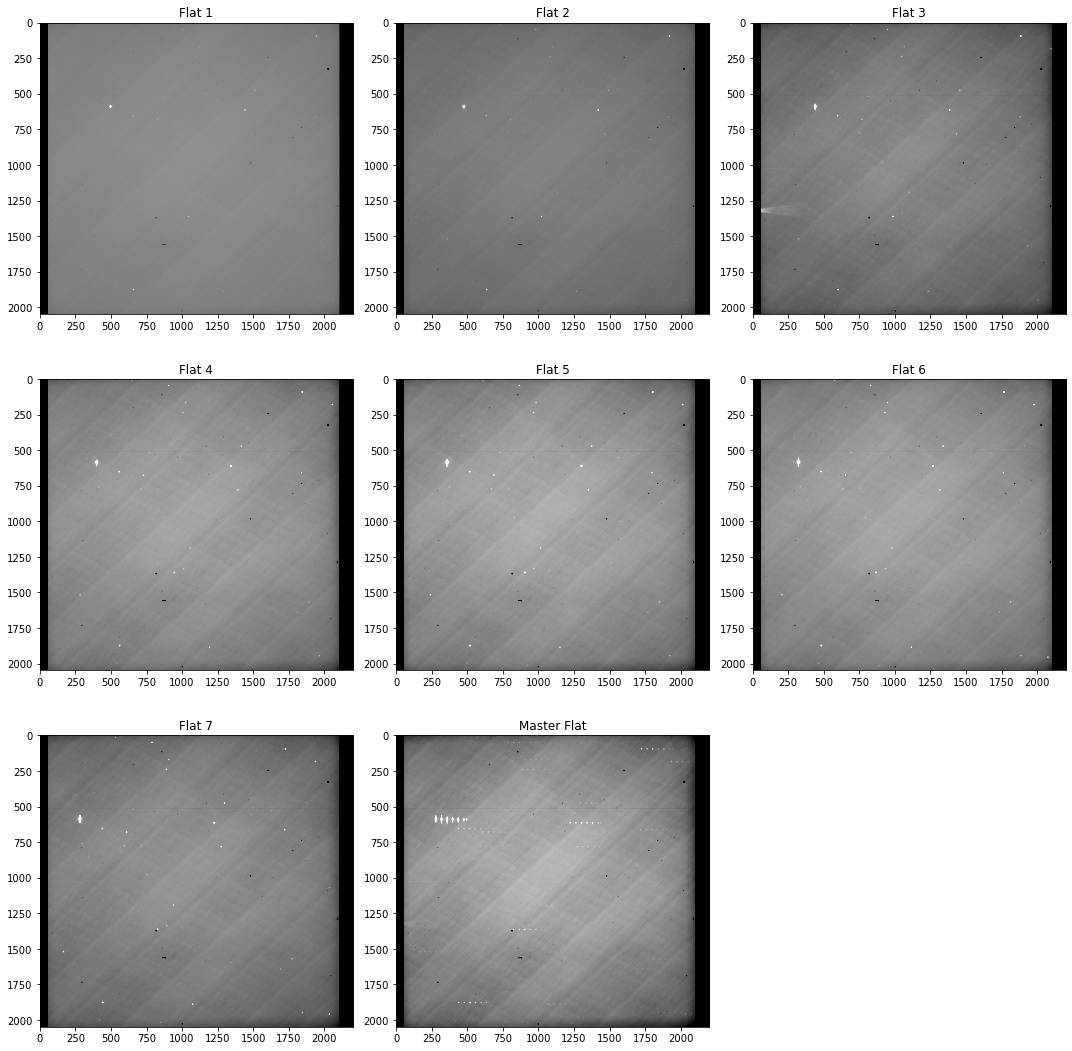

In [3]:
fig,axes = plt.subplots(3,3,figsize=(15,15),tight_layout=True)
axes[0,0].imshow(flat_data[0],vmin=7000,vmax=12500,cmap="gray")
axes[0,0].set_title('Flat 1')
axes[0,1].imshow(flat_data[1],vmin=14000,vmax=20500,cmap="gray")
axes[0,1].set_title('Flat 2')
axes[0,2].imshow(flat_data[2],vmin=26000,vmax=32000,cmap="gray")
axes[0,2].set_title('Flat 3')
axes[1,0].imshow(flat_data[3],vmin=22000,vmax=27000,cmap="gray")
axes[1,0].set_title('Flat 4')
axes[1,1].imshow(flat_data[4],vmin=32000,vmax=38000,cmap="gray")
axes[1,1].set_title('Flat 5')
axes[1,2].imshow(flat_data[5],vmin=27000,vmax=33000,cmap="gray")
axes[1,2].set_title('Flat 6')
axes[2,0].imshow(flat_data[6],vmin=24000,vmax=29000,cmap="gray")
axes[2,0].set_title('Flat 7')
axes[2,1].imshow(flat_combine,vmin=23000,vmax=26000,cmap='gray')
axes[2,1].set_title('Master Flat')
axes[2,2].axis('off')
plt.show()


Just by scanning over these flats, it is clear there are some artifacts that will need to be removed, especially the bright source in the top left corner, as well as other smaller bright spots scattered in these images. To create a master flat without these artifacts, we will have to scale, sigma clip, and weight each image. Scaling the images is important because all of these images have really different mean levels, i.e. some images captured more photons than others and this level difference will need to be accounted for otherwise we'll lose entire images when we apply the sigma clip. Sigma clipping will be the main method the will remove artifacts to create a master flat. Weighting each image will give images with a higher mean count more weight because the higher the counts, the better/more reliable the image is. 

Let's overscan and bias subtract and trim each flat and then we can plot the mean level variation over time to see if the average light levels will impact our combine strategy:

In [4]:
# define the overscan region in the flats
flat_overscan_region = [i[:,2101:2201] for i in flat_data]

# turn data into CCDData
flat_data_ccd = [CCDData(i,unit='adu') for i in flat_data]
flat_overscan_ccd = [CCDData(i,unit='adu') for i in flat_overscan_region]

# define model for overscan subtraction 
model = models.Chebyshev1D(4)

# lets overscan subtract and trim each flat
flat_subtract = [ccd.subtract_overscan(flat_data_ccd[i],overscan=flat_overscan_ccd[i],model=model) for i in np.arange(0,7,1)]
flat_trim = [ccd.trim_image(i[:,53:2101]) for i in flat_subtract]
flat_trim_arr = [np.array(i) for i in flat_trim]
#np.shape(flat_trim_arr)

In [5]:
# let's save the overscan and trimmed flats to the reduced folder
num = 43
flats = [fits.open("./Imaging/a0" + str(i) + ".fits") for i in np.arange(43,50,1)]
for i in flat_trim_arr:
    fits.writeto('./../reduced_data/a0' + str(num) +'ot.fits', i, overwrite=True)
    num+=1

Now, let's create a master bias and do a bias subtraction on the flats

In [6]:
# read in the biases
bias_1 = [fits.open("./Imaging/a0" + str(i) + ".fits") for i in np.arange(93,100,1)]
bias_2 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(100,112,1)]
bias_tot = bias_1+bias_2

# get the data for each bias
bias_data = [i[0].data for i in bias_tot]
bias_overscan_region = [i[:,2101:2200] for i in bias_data]

# turn the bias frames in CCDData
bias_frames = [CCDData(i,unit='adu') for i in bias_data]
bias_overscan = [CCDData(i,unit='adu') for i in bias_overscan_region]

# overscan subtract the bias frames
bias_subtract = [ccd.subtract_overscan(bias_frames[i],overscan=bias_overscan[i],model=model) for i in range(len(bias_data))]

# trim the bias subtracted frames
bias_trim = [ccd.trim_image(i[:,53:2101]) for i in bias_subtract]
reduced_bias = [np.array(i) for i in bias_trim]

#combine bias frames to make a master bias # average with sigma clipping 
master_bias = ccd.combine(bias_trim)

np.shape(master_bias)
#master_bias

(2048, 2048)

In [7]:
np.shape(reduced_bias)

(19, 2048, 2048)

In [8]:
# save the biases that have been overscan subtracted and trimmed
idx = 0
for i in np.arange(93,112,1):
    if i < 100:
        #print('1st',idx,i)
        fits.writeto('./../reduced_data/a0' + str(i) +'ot.fits', reduced_bias[idx], overwrite=True)
        idx+=1
    if i >= 100: 
        #print('2nd',idx,i)
        fits.writeto('./../reduced_data/a0' + str(i) +'ot.fits', reduced_bias[idx], overwrite=True)
        idx+=1

In [9]:
# bias subtract the overscan subtracted flats
bias_over_subtracted = [ccd.subtract_bias(i, master_bias) for i in flat_trim]
reduced_flats = [np.array(i) for i in bias_over_subtracted]
np.shape(reduced_flats)

(7, 2048, 2048)

Let's plot the mean level of each reduced flat versus the time the flat was taken to see how the flats vary with time

In [10]:
# calculate the mean level of each flat and plot it vs time the flat was taken 
flat_head = [i[0].header for i in flats]
flat_date = [i["DATE-OBS"] for i in flat_head]
flat_time = [i[11:23] for i in flat_date]

# compute the mean level of the overscan regions 
flat_mean = [np.mean(i) for i in reduced_flats]
flat_std = np.std(flat_mean)
print(flat_mean,flat_std)

# convert h:m:s string to seconds, courtesy of a function found on stack overflow (god bless the internet)
def get_sec(time_str):
    """Get Seconds from time."""
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(float(s))

flat_time_sec = []
for i in flat_time:
    time = get_sec(i)
    flat_time_sec.append(time)
print(flat_time_sec)

[9179.964252547214, 16290.642691287763, 28021.52933541276, 24034.348802059027, 34666.46664223108, 29622.14690237396, 25711.691242274053] 7959.912700039085
[8490, 8523, 8567, 8615, 8657, 8709, 8756]


## Compare the average light levels in your flat and say how this will impact your combine strategy.

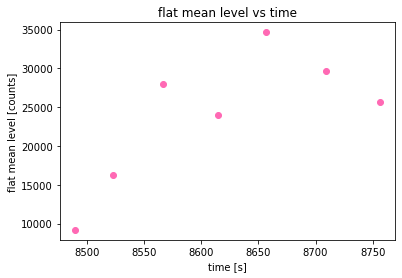

In [11]:
# plot mean level vs time
plt.scatter(flat_time_sec,flat_mean,c='hotpink')
plt.xlabel('time [s]')
plt.ylabel('flat mean level [counts]')
plt.title('flat mean level vs time')
plt.show()

This plot shows us that the mean level of the flats increases as time goes on (these were probably taken around dawn). This variation in level means that we will definitely have to scale the flats and apply a weighted mean so that the images with higher photons counts carry more weight in defining the master flat.

Next, we want to scale all our flat frames to a common mean. This will allow us to perform sigma cuts without cutting entire images. 

In [12]:
# scaled flats 
scaled_flats = [i/np.mean(i) for i in reduced_flats]
scaled_flats_ccd = [CCDData(i,unit='adu') for i in scaled_flats]

## After scaling to a common mean, discuss the advangtages and disadvantages of making a master flat field image from:
### - A straight average of all V flat frames
### - A straight median of all V flat frames
### - An average where outlier pixels are rejected if they are more than 3$\sigma$ away from the mean
### - An average where outlier pixels are rejected and the weighted mean is obtained by weighting each image by the mean counts in the original image. This way, bright flat field exposures with higher count rates are given more weight than flats with lower light levels. 
## Which of these strategies, if any, is best? Or is some combination the right approach? Show plots and metrics like RMS to defend your conclusions. 

In [13]:
# straight average of all V flat frames
master_flat_avg = ccd.combine(scaled_flats_ccd,method='average')
master_flat_avg_std = np.std(master_flat_avg)

In [14]:
# straight median of all V flat frames
master_flat_med = ccd.combine(scaled_flats_ccd,method='median')
master_flat_med_std = np.std(master_flat_med)

In [15]:
# mean with sigma clipping (sigma clipping = 2 sigma)
master_flat_avg_clip = ccd.combine(scaled_flats_ccd,method='average',sigma_clip=True,sigma_clip_low_thresh=2, sigma_clip_high_thresh=2,sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std)
master_flat_avg_clip_std = np.std(master_flat_avg_clip)

In [16]:
# an average where outlier pixels are rejects and the weighted mean is obtained by each image by the mean counts in the original image
# first we need to sigma clip each image using astropy.stats.sigma_clip
sigma_clip_v = sigma_clip(scaled_flats,sigma=2,axis=0,masked=True)
print(np.shape(sigma_clip_v))

# now, we can combine the sigma clipped flats using a weighted average 
weights = [np.mean(i) for i in reduced_flats]
weight_combine = np.ma.average(sigma_clip_v,axis=0,weights=weights)
weight_combine_std = np.std(weight_combine)

(7, 2048, 2048)


Let's print out the RMS value and final image of each combination technique to get an idea of which works best:

In [17]:
print('straight mean combination: ',master_flat_avg_std)
print('straight median combination: ', master_flat_med_std)
print('mean combination 2sigma clipping: ', master_flat_avg_clip_std)
print('weighted mean obtained from sigma clipped images:', weight_combine_std)

straight mean combination:  0.015514589862209
straight median combination:  0.01456057175453898
mean combination 2sigma clipping:  0.01450733955526976
weighted mean obtained from sigma clipped images: 0.014470339322232581


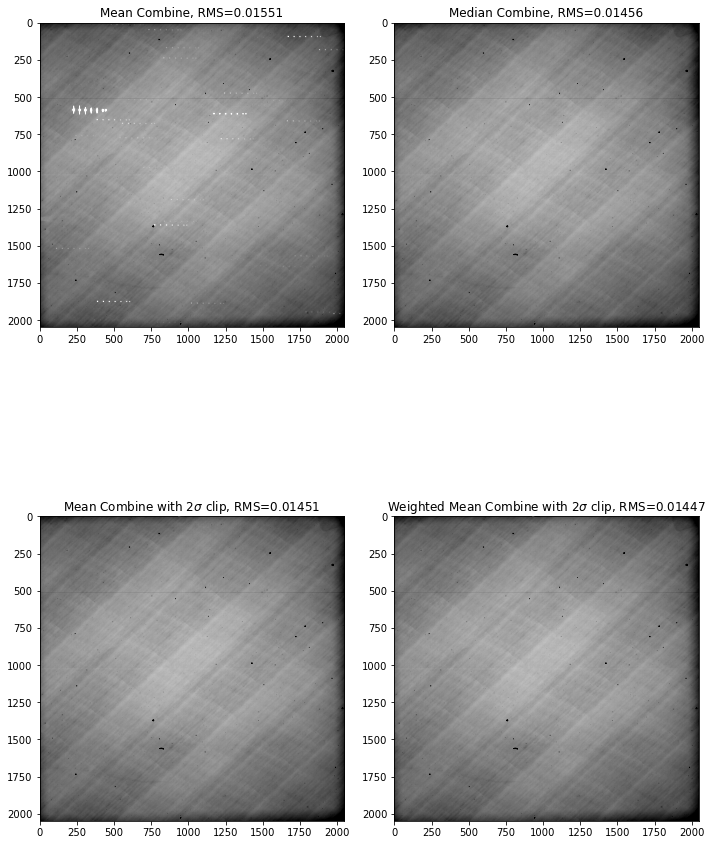

In [18]:
# plot each combination technique
fig,axes = plt.subplots(2,2,figsize=(10,15),tight_layout=True)
axes[0,0].imshow(master_flat_avg,vmin=0.95,vmax=1.05,cmap='gray')
axes[0,0].set_title('Mean Combine, RMS='+str(round(master_flat_avg_std,5)))
axes[0,1].imshow(master_flat_med,vmin=0.95,vmax=1.05,cmap='gray')
axes[0,1].set_title('Median Combine, RMS='+str(round(master_flat_med_std,5)))
axes[1,0].imshow(master_flat_avg_clip,vmin=0.95,vmax=1.05,cmap='gray')
axes[1,0].set_title('Mean Combine with 2$\sigma$ clip, RMS='+str(round(master_flat_avg_clip_std,5)))
axes[1,1].imshow(weight_combine,vmin=0.95,vmax=1.05,cmap='gray')
axes[1,1].set_title('Weighted Mean Combine with 2$\sigma$ clip, RMS='+str(round(weight_combine_std,5)))
plt.show()

After a quick visual inspection, it is clear that the mean combine is the worst of all combination techniques. There are many artifacts still in the image, so mean combine isn't sufficient for creating a master flat.  This is also reflected in the RMS value, it has the worst out of all the techniques. 
It is a bit more difficult to tell the which of the other techniques is best by simply looking at them because they all seem to have successfully removed the bright artifacts that we want gone, so we will compare RMS values. The weighted mean combination technique has the best RMS value out of all of them, so it's sufficient to say that the sigma clipping on top of the weighted mean combine is the best combination technique. 

## 2: Combine your flat field images to make a master flat for all filters using the strategy you arrived at above. 

First, let's read in the data for the flats in each filter:

In [19]:
# Halpha 
flat_halpha1 = [fits.open("./Imaging/a00" + str(i) + ".fits") for i in np.arange(5,10,1)]
flat_halpha2 = [fits.open("./Imaging/a0" + str(i) + ".fits") for i in np.arange(10,21,1)]
flat_halpha = flat_halpha1 + flat_halpha2
flat_halpha_data = [i[0].data for i in flat_halpha]
flat_halpha_ccd = [CCDData(i,unit='adu') for i in flat_halpha_data] # turn into CCDData
flat_halpha_overscan_region = [i[:,2101:2201] for i in flat_halpha_data] # define the overscan region 
flat_halpha_overscan_ccd = [CCDData(i,unit='adu') for i in flat_halpha_overscan_region] # turn overscan region into CCDData

# U 
flat_u = [fits.open("./Imaging/a0" + str(i) + ".fits") for i in np.arange(22,29,1)]
flat_u_data = [i[0].data for i in flat_u]
flat_u_ccd = CCDData(flat_u_data,unit='adu') # turn into CCDData
flat_u_overscan_region = [i[:,2101:2201] for i in flat_u_data] # define the overscan region 
flat_u_overscan_ccd = CCDData(flat_u_overscan_region,unit='adu') # turn overscan region into CCDData

# B 
flat_b = [fits.open("./Imaging/a0" + str(i) + ".fits") for i in np.arange(32,43,1)]
flat_b_data = [i[0].data for i in flat_b]
flat_b_ccd = CCDData(flat_b_data,unit='adu') # turn into CCDData
flat_b_overscan_region = [i[:,2101:2201] for i in flat_b_data] # define the overscan region 
flat_b_overscan_ccd = CCDData(flat_b_overscan_region,unit='adu') # turn overscan region into CCDData

# V is already read in 

# R
flat_r = [fits.open("./Imaging/a0" + str(i) + ".fits") for i in np.arange(50,56,1)]
flat_r_data = [i[0].data for i in flat_r]
flat_r_ccd = CCDData(flat_r_data,unit='adu') # turn into CCDData
flat_r_overscan_region = [i[:,2101:2201] for i in flat_r_data] # define the overscan region 
flat_r_overscan_ccd = CCDData(flat_r_overscan_region,unit='adu') # turn overscan region into CCDData

# I 
flat_i = [fits.open("./Imaging/a0" + str(i) + ".fits") for i in np.arange(57,63,1)]
flat_i_data = [i[0].data for i in flat_i]
flat_i_ccd = CCDData(flat_i_data,unit='adu') # turn into CCDData
flat_i_overscan_region = [i[:,2101:2201] for i in flat_i_data] # define the overscan region 
flat_i_overscan_ccd = CCDData(flat_i_overscan_region,unit='adu') # turn overscan region into CCDData

In [20]:
# here's a function that performs an overscan subtraction, bias subtraction, and trim to the images passed into the function

def master_flat(data,model,master_bias):
    
    '''
    This function takes in an array of images, a model, and a master_bias to create a master flat by performing
    an overscan subtraction, a bias subtraction, and trimming to each flat, and then combining them using a 
    weighted mean. 
    
    Params: 
    data - a list of images 
    model - model that describes the overscan region 
    master_bias - master bias image 
    
    Returns: 
    weighted_mean - master flat created using a sigma clip and weighted mean 
    '''
    
    # turn data into CCDData
    ccd_data = [CCDData(i,unit='adu') for i in data]
    
    # define overscan region and turn data into CCDData
    overscan_region = [i[:,2101:2201] for i in data]
    ccd_overscan_region = [CCDData(i,unit='adu') for i in overscan_region]
    
    # overscan subtract
    overscan_subtract = [ccd.subtract_overscan(ccd_data[i],overscan=ccd_overscan_region[i],model=model) for i in range(len(data))]
    
    # trim image
    trim = [ccd.trim_image(i[:,53:2101]) for i in overscan_subtract]
    
    # bias subtraction
    bias_subtract = [ccd.subtract_bias(i,master_bias) for i in trim]
    
    # turn into numpy array
    reduced_data = [np.array(i) for i in bias_subtract]
    
    # scale the reduced flats 
    scaled = [i/np.mean(i)for i in reduced_data]
    scaled_ccd = [CCDData(i,unit='adu') for i in scaled]

    # sigma clip the scaled flats
    sigma_clipped_data = sigma_clip(scaled,sigma=2,axis=0,masked=True)
    
    # calculate the weighted mean 
    weights = [np.mean(i) for i in reduced_data]
    weighted_mean = np.ma.average(sigma_clipped_data,axis=0,weights=weights)
    
    return weighted_mean

In [21]:
# let's create a master flat for each filter using the weighted mean combination method

# halpha
master_halpha = master_flat(flat_halpha_data,model,master_bias)

# u 
master_u = master_flat(flat_u_data,model,master_bias)

# b
master_b = master_flat(flat_b_data,model,master_bias)

# r
master_r = master_flat(flat_r_data,model,master_bias)

# i 
master_i = master_flat(flat_i_data,model,master_bias)

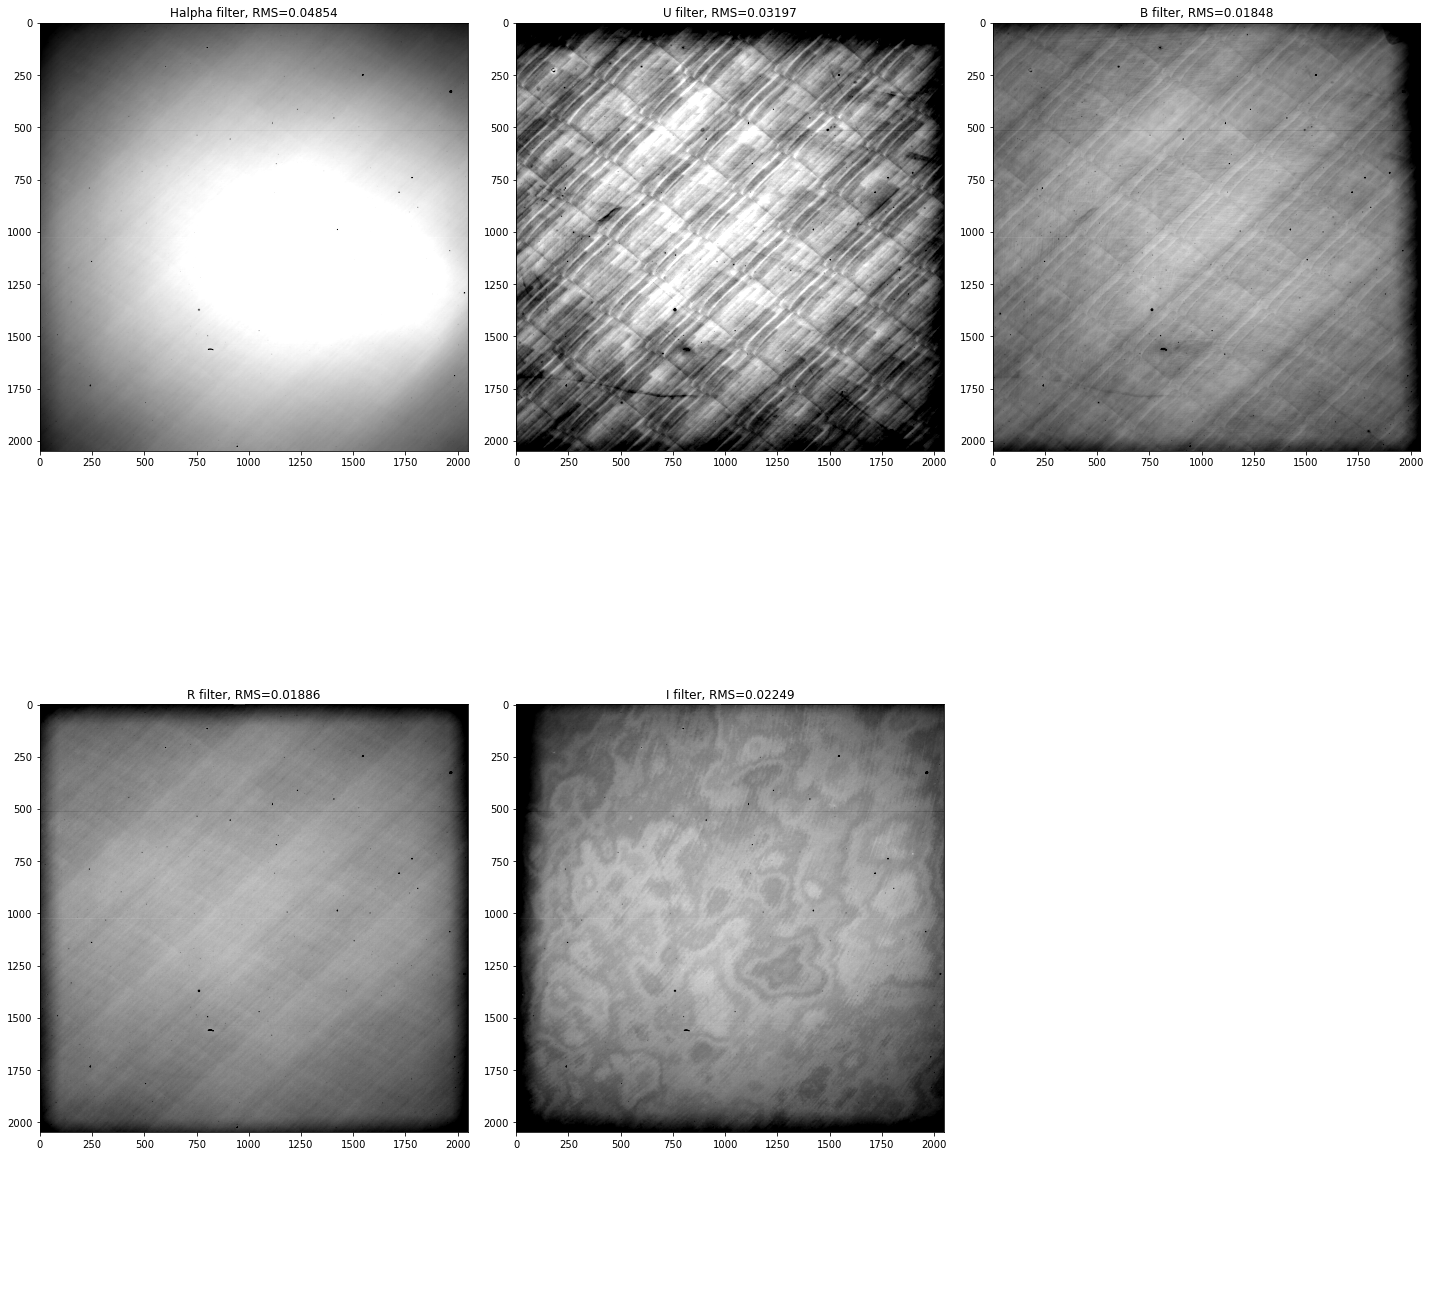

In [22]:
# let's see what these master flats look like 
fig,axes = plt.subplots(2,3,figsize=(20,20),tight_layout=True)
axes[0,0].imshow(master_halpha,vmin=0.87,vmax=1.05,cmap='gray')
axes[0,0].set_title('Halpha filter, RMS='+str(round(np.std(master_halpha),5)))
axes[0,1].imshow(master_u,vmin=0.95,vmax=1.05,cmap='gray')
axes[0,1].set_title('U filter, RMS='+str(round(np.std(master_u),5)))
axes[0,2].imshow(master_b,vmin=0.95,vmax=1.05,cmap='gray')
axes[0,2].set_title('B filter, RMS='+str(round(np.std(master_b),5)))
axes[1,0].imshow(master_r,vmin=0.95,vmax=1.05,cmap='gray')
axes[1,0].set_title('R filter, RMS='+str(round(np.std(master_r),5)))
axes[1,1].imshow(master_i,vmin=0.95,vmax=1.05,cmap='gray')
axes[1,1].set_title('I filter, RMS='+str(round(np.std(master_i),5)))
axes[1,2].axis('off')
plt.show()

These master flats all look different, which is isn't good or bad. Knowing that they look different means that we will have to treat each filter differently when we remove the flats from the science frames.

# 3: Normalize your flat field image for each filter so that it has a mean of 1.

In [23]:
# normalize: find the mean in the image and divide by that mean 

# v 
normal_v = weight_combine / np.mean(weight_combine)
#print(normal_v)

# halpha
normal_ha = master_halpha / np.mean(master_halpha)

# u
normal_u = master_u / np.mean(master_u)

# b 
normal_b = master_b / np.mean(master_b)

# r 
normal_r = master_r / np.mean(master_r)

# i 
normal_i = master_i / np.mean(master_i)

# 4: Divide all your science frames by your normalized flat field.

As mentioned before, because the master flats all look so different, we will have to divide all the science frames by the normalized flat fields by their respective filters. So, divide the V filter science frames by the V master flat, the B filter science frames by the B master flat, etc. If the master flats all looked the same, then you could use just one filter for all the science frames. 

In [24]:
# read in all the science frames 

# PG 1633+099

# v
pg_v1 = [fits.open("./Imaging/a0" + str(i) + ".fits") for i in np.arange(64,81,1)]
pg_v2 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(134,136,1)]
pg_v3 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(206,208,1)]
#pg_v4 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(227,231,1)]
pg_v5 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(241,243,1)]

# u
pg_u1 = [fits.open("./Imaging/a0" + str(i) + ".fits") for i in np.arange(81,83,1)]
pg_u2 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(130,132,1)]
pg_u3 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(202,204,1)]
#pg_u4 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(221,223,1)]
#pg_u5 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(237,239,1)]

# b 
pg_b1 = [fits.open("./Imaging/a0" + str(i) + ".fits") for i in np.arange(83,85,1)]
pg_b2 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(132,134,1)]
pg_b3 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(204,206,1)]
#pg_b4 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(223,227,1)]
pg_b5 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(239,241,1)]

# r 
pg_r1 = [fits.open("./Imaging/a0" + str(i) + ".fits") for i in np.arange(87,89,1)]
pg_r2 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(136,138,1)]
pg_r3 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(208,210,1)]
#pg_r4 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(231,233,1)]
#pg_r5 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(235,237,1)]
pg_r6 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(243,245,1)]

#i
pg_i1 = [fits.open("./Imaging/a0" + str(i) + ".fits") for i in np.arange(89,91,1)]
pg_i2 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(138,140,1)]
pg_i3 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(210,212,1)]
#pg_i4 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(233,235,1)]
pg_i5 = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(245,247,1)]

#halpha
pg_ha = [fits.open("./Imaging/a0" + str(i) + ".fits") for i in np.arange(91,93,1)]

In [25]:
# PV Cep 

# b
pv_b = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(112,115,1)]
pv_b_data = [i[0].data for i in pv_b]

# v
pv_v = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(115,121,1)]
pv_v_data = [i[0].data for i in pv_v]

# r
pv_r = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(121,124,1)]
pv_r_data = [i[0].data for i in pv_r]

# i
pv_i = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(124,127,1)]
pv_i_data = [i[0].data for i in pv_i]

# halpha
pv_ha = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(127,130,1)]
pv_ha_data = [i[0].data for i in pv_ha]

In [26]:
# Michael#1

# i 
m_i = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(142,144,1)]

# r
m_r = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(144,146,1)]

# v 
m_v = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(146,148,1)]

# b 
m_b = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(148,150,1)]

# u 
m_u = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(150,152,1)]


In [27]:
# NGC6823

# i 
ngc_i = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(153,155,1)]

# r 
ngc_r = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(155,157,1)]

# v 
ngc_v = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(157,159,1)]

# b 
ngc_b = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(160,162,1)]

# u 
ngc_u = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(162,164,1)]

In [28]:
# M16 

# b 
m16_b = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(165,170,1)]

# v 
m16_v = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(170,173,1)]

# r 
m16_r = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(173,176,1)]

# halpha 
m16_ha = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(176,179,1)]

# u 
m16_u = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(179,182,1)]

In [29]:
# NGC7006

# v
ngc7006_v = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(183,185,1)]

# r
ngc7006_r = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(185,187,1)]

# i 
ngc7006_i = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(187,189,1)]

# b 
ngc7006_b = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(189,191,1)]

# u
ngc7006_u = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(191,193,1)]

In [30]:
# m101

# r 
m101_r = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(212,215,1)]

# v 
m101_v = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(215,218,1)]

# b 
m101_b = [fits.open("./Imaging/a" + str(i) + ".fits") for i in np.arange(218,221,1)]

In [31]:
# let's compile all the frames that have the same filter together and grab the data:

# v
v_science = pg_v1+pg_v2+pg_v3+pg_v5+pv_b+m_v+ngc_v+m16_v+ngc7006_v+m101_v
v_data = pg_v_data = [i[0].data for i in v_science]

# u 
u_science = pg_u1+pg_u2+pg_u3+m_u+ngc_u+m16_u+ngc7006_u
u_data = [i[0].data for i in u_science]

# b 
b_science = pg_b1+pg_b2+pg_b3+pg_b5+pv_b+m_b+ngc_b+m16_b+ngc7006_b+m101_b
b_data = [i[0].data for i in b_science]

# r 
r_science = pg_r1+pg_r2+pg_r3+pg_r6+pv_r+m_r+ngc_r+m16_r+ngc7006_r+m101_r
r_data = [i[0].data for i in r_science]

# i 
i_science = pg_i1+pg_i2+pg_i3+pg_i5+pv_i+m_i+ngc_i+ngc7006_i
i_data = [i[0].data for i in i_science]

# halpha 
ha_science = pg_ha+pv_ha+m16_ha
ha_data = [i[0].data for i in ha_science]

In [32]:
# let's use the function below to overscan and bias subtract and trim the science frames:
def subtract_and_trim(data,model,master_bias):
    
    """
    This function performs an overscan and bias subtraction on images passed into the function. It also trims the 
    overscan regions off the specified images. 
    
    Params: 
    data - a list of images
    model - the overscan region model 
    master_bias - master_bias image
    
    Returns: 
    reduced_data - list of images that has been overscan and bias subtracted and trimmed
    """
    
    # turn data into CCDData
    ccd_data = [CCDData(i,unit='adu') for i in data]
    # define overscan region and turn data into CCDData
    overscan_region = [i[:,2101:2201] for i in data]
    ccd_overscan_region = [CCDData(i,unit='adu') for i in overscan_region]
    # overscan subtract
    overscan_subtract = [ccd.subtract_overscan(ccd_data[i],overscan=ccd_overscan_region[i],model=model) for i in range(len(data))]
    # trim image
    trim = [ccd.trim_image(i[:,53:2101]) for i in overscan_subtract]
    # bias subtraction
    bias_subtract = [ccd.subtract_bias(i,master_bias) for i in trim]
    # turn into numpy array
    reduced_data = [np.array(i) for i in bias_subtract]
    return reduced_data

In [33]:
# let's subtract and trim the science frames
reduced_v = subtract_and_trim(v_data,model,master_bias)
reduced_u = subtract_and_trim(u_data,model,master_bias)
reduced_b = subtract_and_trim(b_data,model,master_bias)
reduced_r = subtract_and_trim(r_data,model,master_bias)
reduced_i = subtract_and_trim(i_data,model,master_bias)
reduced_ha = subtract_and_trim(ha_data,model,master_bias)

In [34]:
# now we can divide the science frames by our normalized flat fields
# it's important to divide each science filter by their respective flat frames 
science_v_divide = np.divide(reduced_v,normal_v)
science_u_divide = np.divide(reduced_u,normal_u)
science_b_divide = np.divide(reduced_b,normal_b)
science_r_divide = np.divide(reduced_r,normal_r)
science_i_divide = np.divide(reduced_i,normal_i)
science_ha_divide = np.divide(reduced_ha,normal_ha)

# 5: Compute the gain and read noise for this CCD using a couple of the flat field images and bias images. Decide, by examination, what sections of each image you should use to determine these values.  

In [35]:
# let's flat field all the flats:
flat_field_v = [np.divide(i,normal_v) for i in reduced_flats]
flat_field_u = [np.divide(i,normal_u) for i in subtract_and_trim(flat_u_data,model,master_bias)] 
flat_field_b = [np.divide(i,normal_b) for i in subtract_and_trim(flat_b_data,model,master_bias)] 
flat_field_r = [np.divide(i,normal_r) for i in subtract_and_trim(flat_r_data,model,master_bias)] 
flat_field_i = [np.divide(i,normal_i) for i in subtract_and_trim(flat_i_data,model,master_bias)] 
flat_field_ha = [np.divide(i,normal_ha) for i in subtract_and_trim(flat_halpha_data,model,master_bias)] 

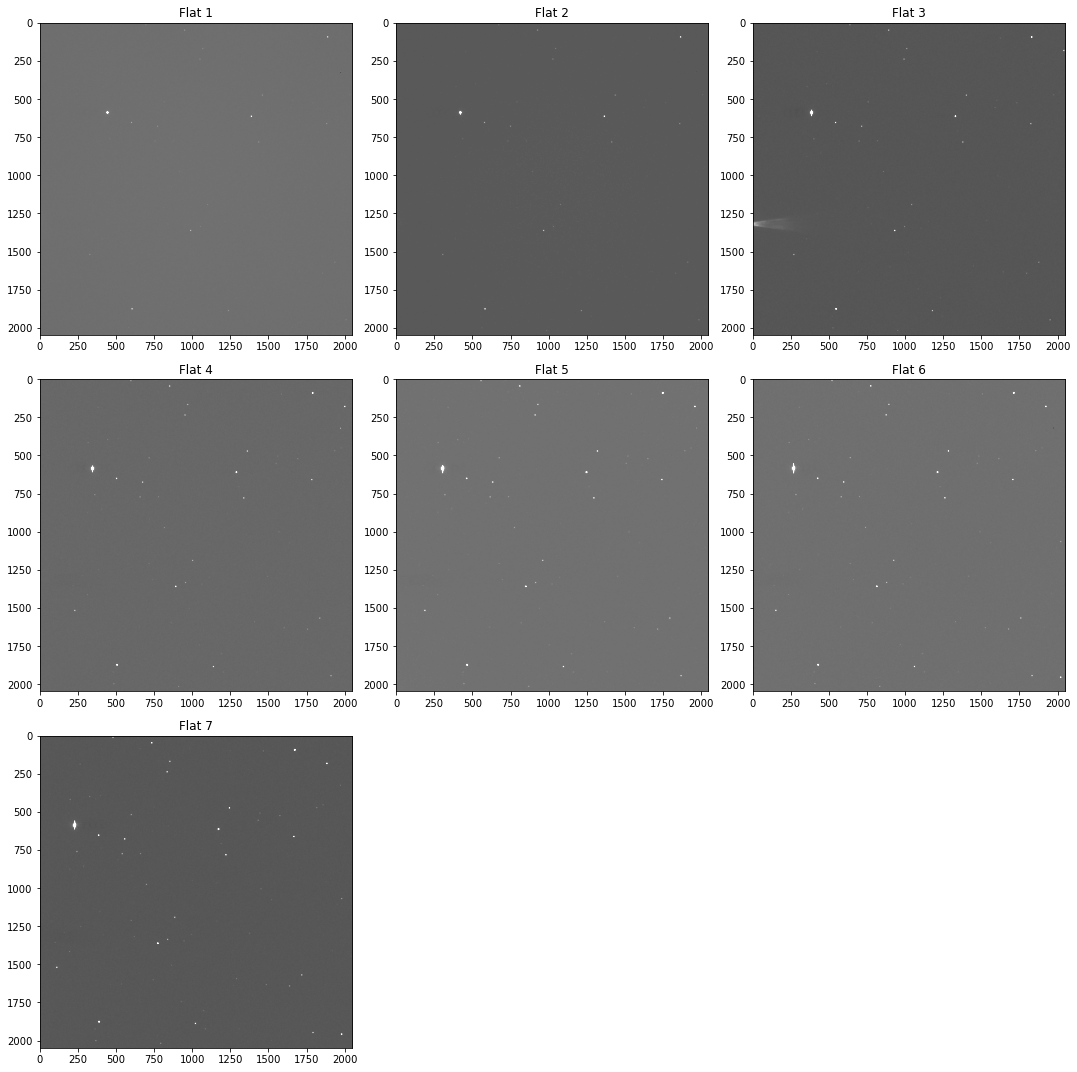

In [36]:
fig,axes = plt.subplots(3,3,figsize=(15,15),tight_layout=True)
axes[0,0].imshow(flat_field_v[0],vmin=7000,vmax=12000,cmap="gray")
axes[0,0].set_title('Flat 1')
axes[0,1].imshow(flat_field_v[1],vmin=14000,vmax=20500,cmap="gray")
axes[0,1].set_title('Flat 2')
axes[0,2].imshow(flat_field_v[2],vmin=26000,vmax=32000,cmap="gray")
axes[0,2].set_title('Flat 3')
axes[1,0].imshow(flat_field_v[3],vmin=22000,vmax=27000,cmap="gray")
axes[1,0].set_title('Flat 4')
axes[1,1].imshow(flat_field_v[4],vmin=32000,vmax=38000,cmap="gray")
axes[1,1].set_title('Flat 5')
axes[1,2].imshow(flat_field_v[5],vmin=27000,vmax=33000,cmap="gray")
axes[1,2].set_title('Flat 6')
axes[2,0].imshow(flat_field_v[6],vmin=24000,vmax=29000,cmap="gray")
axes[2,0].set_title('Flat 7')
axes[2,1].axis('off')
axes[2,2].axis('off')
plt.show()

To calculate the gain, we'll use the equation given in Howell's Handbook of CCD Astronomy: 
$$Gain = \frac{(\overline{F}_{1} + \overline{F}_{2}) - (\overline{B}_{1} + \overline{B}_{2})}{\sigma^{2}_{F_{1}-F_{2}} - \sigma^{2}_{B_{1}-B_{2}}}$$
Before, we calculate the gain, we need to crop the images so that we're only looking at specific regions in the images. This is important because when we look at the flat fielded flats, we can see that the artifacts are still there and we want those elimated as much as possible, so we'll focus on regions that have less artifacts in them. The cropped function below crops images to focus on the center or other specific regions of the pictures. We see the least amount of artifacts near the mid-right regions of the images, so we'll focus on that region. 

In [37]:
def crop(data,size=1000):
    """
    This function crops the image to focus only on a specific region with the least amount of artifacts. You can 
    manually change the regions to crop images differently.
    
    Params: 
    data - image
    size - how big you want the cropped area/what region you want to look at, i.e. 1000 refers to a custom region 
    
    Returns: 
    cropped - cropped image
    """
    data = np.array(data)
    if size == 200: # 200x200 pixel array
        row_min = int(len(data)/2-100)
        row_max = int(len(data)/2+100)
        cropped = data[row_min:row_max:,row_min:row_max]
    elif size == 400: # 400x400 pixel array
        row_min = int(len(data)/2-200)
        row_max = int(len(data)/2+200)
        cropped = data[row_min:row_max:,row_min:row_max]
    elif size == 600: # 600x600 pixel array
        row_min = int(len(data)/2-300)
        row_max = int(len(data)/2+300)
        cropped = data[row_min:row_max:,row_min:row_max]
    elif size == 1000: 
        cropped = data[1000:1500:,1250:1500]
    return cropped

In [38]:
def gain(flat1,flat2,bias1,bias2):
    """
    This function takes in two flats and two biases and calculates the gain
    
    Params: 
    flat1 - a cropped flat
    flat2 - a cropped flat
    bias1 - a cropped bias
    bias2 - a cropped bias 
    
    Returns: 
    gain - the calculated gain 
    """
    gain = np.divide(((np.mean(flat1)+np.mean(flat2))-(np.mean(bias1)+np.mean(bias2))),(np.var(flat1-flat2)-np.var(bias1+bias2)))
    return gain

Let's calculate the gain of two flats and two biases: 

In [39]:
gain1 = gain(crop(flat_field_v[4]),crop(flat_field_v[5]),crop(reduced_bias[0]),crop(reduced_bias[1]))

In [40]:
gain1

1.5942737487716938

This gain seems reasonable, but let's cross check this calculation by plotting the signal variance versus the signal source in ADU of a couple V flats. The slope of this graph will also give us the gain.

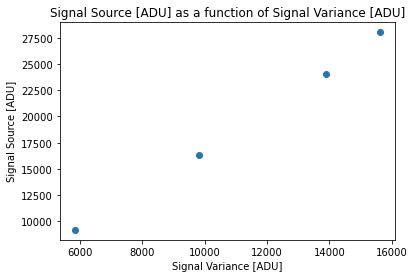

In [41]:
# lets plot signal variance vs. signal source in ADU 
var = np.array([np.var(crop(flat_field_v[0])),np.var(crop(flat_field_v[1])),np.var(crop(flat_field_v[2])),np.var(crop(flat_field_v[3]))])
sa = np.array([np.mean(crop(flat_field_v[0])),np.mean(crop(flat_field_v[1])),np.mean(crop(flat_field_v[2])),np.mean(crop(flat_field_v[3]))])

plt.scatter(var,sa)
plt.xlabel('Signal Variance [ADU]')
plt.ylabel('Signal Source [ADU]')
plt.title('Signal Source [ADU] as a function of Signal Variance [ADU]')
plt.show()

In [42]:
# let's calculate the slope of this graph
m,b = np.polyfit(var,sa,1) 
print('Gain determine by slope:',m)

Gain determine by slope: 1.9121526833155198


This is gain is probably a little more reliable because it is determined by using multiple flats, but it is reassuing to know that both calculations are relatively close (i.e. ~2). 

Now, we can use the gain above to calculate the read noise, which is given by the following equation: 
$$ Read Noise = \frac{Gain(\sigma_{B_{1}-B_{2}})}{\sqrt{2}}$$

In [43]:
def read_noise(gain,bias1,bias2):
    """
    This function calculates the read noise given a gain and two biases
    
    Params:
    gain - gain 
    bias1 - a cropped bias
    bias2 - a cropped bias
    
    Returns: 
    rn - read noise
    """
    rn = gain * np.std(bias1-bias2) / np.sqrt(2)
    return rn

In [44]:
print('Read noise:', read_noise(m,crop(reduced_bias[0]),crop(reduced_bias[1])))

Read noise: 16.451123209078837
